In [2]:
import sys
sys.path.append("./../")
from evaluation.gsm8k import judge
import json
from thirdparty.openai.grade_school_math.dataset import read_jsonl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bootstrap
import os
from transformers import AutoTokenizer,AddedToken


/dlabdata1/baldwin/miniconda3/envs/pausetok/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
reference = read_jsonl("./../data/gsm8k/test.json")
random_pause_injected_mistral = read_jsonl(f"../data/gsm8k_10_random_pause_injected_mistral/test.json")
names = list(filter(lambda x: x.startswith("rc_mistral"), os.listdir("./../result/")))
name2data = {}
for name in names:
    with open(f"./../result/{name}", "r") as f:
        name2data[name] = json.load(f)



In [4]:
mistral_pause_augm_tokenizer = AutoTokenizer.from_pretrained("/dlabdata1/llm_hub/Mistral-7B-v0.1")
pause_token = AddedToken(
        "<|pause|>", 
        single_word=False, 
        lstrip=True, 
        rstrip=True
    )
mistral_pause_augm_tokenizer.add_tokens([pause_token], special_tokens=True)
mistral_pause_augm_tokenizer.pad_token=mistral_pause_augm_tokenizer.unk_token
mistral_pause_augm_tokenizer

LlamaTokenizerFast(name_or_path='/dlabdata1/llm_hub/Mistral-7B-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("<|pause|>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=True),
}

In [5]:
pause_token_id = 32000
mistral_pause_augm_tokenizer.convert_tokens_to_ids("<|pause|>")

32000

In [37]:
def pause_injection_stats(ds,mistral_pause_augm_tokenizer):
    tokenized_ds = mistral_pause_augm_tokenizer(ds)["input_ids"]
    
    pause_token_occurence_positions_per_sentence = []
    
    ##Find all positions where pause token appears
    for seq in tokenized_ds:
        
        paus_tok_occ_pos = \
            list(
                map(
                    lambda x: x[0],
                    filter(
                        lambda x: x[1] == pause_token_id,
                        enumerate(seq)
                    )
                )
            )
        
        pause_token_occurence_positions_per_sentence.append(paus_tok_occ_pos)
    
    n_pauses_per_sentence = list(map(lambda x: len(x), pause_token_occurence_positions_per_sentence))
    
    tokens_before_pause = []
    tokens_after_pause = []
    
    for i,sent in enumerate(pause_token_occurence_positions_per_sentence):
        for pos in sent:
            if pos == 0:
                tokens_before_pause.append(mistral_pause_augm_tokenizer.pad_token_id)
            else:
                tokens_before_pause.append(tokenized_ds[i][pos-1])
            if pos == len(tokenized_ds[i])-1:
                tokens_after_pause.append(mistral_pause_augm_tokenizer.pad_token_id)
            else:
                tokens_after_pause.append(tokenized_ds[i][pos+1])
    words_after_pause = mistral_pause_augm_tokenizer.batch_decode(tokens_after_pause)
    words_before_pause = mistral_pause_augm_tokenizer.batch_decode(tokens_before_pause)
    pause_token_occurence_positions = [item for sublist in pause_token_occurence_positions_per_sentence for item in sublist]
    
    #Get sequence length of each sample
    seq_lengths = list(map(lambda x: len(x), tokenized_ds))
    max_length = max(seq_lengths)
    
    #Count how many times pause token appears at each seq position in datase
    position_occurence = np.zeros((max_length))

    for length in seq_lengths:
        seq_pos_occ = np.zeros((max_length))
        seq_pos_occ[:length] = 1
        position_occurence += seq_pos_occ
    
    #Count how many times pause token appears at each seq position in dataset
    unique_values, counts = np.unique(pause_token_occurence_positions , return_counts=True)
    #Normalize counts by position occurence
    normalized_counts = counts * 1/position_occurence[unique_values]

    return {
        "normalized_counts": normalized_counts,
        "counts": counts ,
        "position_occurence": position_occurence,
        "pause_token_occurence_positions": pause_token_occurence_positions,
        "words_after_pause": words_after_pause,
        "words_before_pause": words_before_pause,
        "n_pauses_per_sentence": n_pauses_per_sentence
    }

In [38]:
from collections import Counter

def plot_pause_token_occurrences(res):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(res["normalized_counts"])), res["normalized_counts"])
    plt.xlabel('Sequence Position')
    plt.ylabel('Normalized Occurrences of Pause Token')
    plt.title('Normalized Occurrences of Pause Token in Dataset')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(res["counts"])), res["counts"])
    plt.xlabel('Sequence Position')
    plt.ylabel('Occurrences of Pause Token')
    plt.title('Occurrences of Pause Token in Dataset')
    plt.tight_layout()
    plt.show()

def plot_word_occurrences(string_list, top_n=None, title=None):
    # Flatten the list of strings into a single string
    combined_string = ' '.join(string_list)
    
    # Tokenize the string into words
    words = combined_string.split()
    
    # Count the occurrences of each word
    word_counts = Counter(words)
    
    # Sort the word counts by frequency
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Extract sorted words and counts
    sorted_words = [word for word, count in sorted_word_counts[:top_n]]
    sorted_counts = [count for word, count in sorted_word_counts[:top_n]]
    
    # Plot the occurrences
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_words, sorted_counts)
    plt.xlabel('Words')
    plt.ylabel('Occurrences')
    plt.title('Top {} Occurrences of Words {}'.format(top_n if top_n is not None else "All", title))
    plt.xticks(rotation=45, ha='right', fontsize=6)
    plt.tight_layout()
    plt.show()

In [53]:
import numpy as np

def kl_divergence_from_counts(counts_p, counts_q):
    """
    Compute the Kullback-Leibler (KL) divergence between two lists of counts.

    Args:
    counts_p: list or numpy array, representing the counts from distribution P.
    counts_q: list or numpy array, representing the counts from distribution Q.

    Returns:
    kl_div: float, the KL divergence from P to Q.
    """
    # Create a set of all unique elements in both counts_p and counts_q
    all_elements = set(counts_p) | set(counts_q)
    
    # Convert lists to numpy arrays if they are not already
    counts_p = np.array(counts_p)
    counts_q = np.array(counts_q)
    
    # Initialize arrays to hold aligned counts
    aligned_counts_p = np.zeros(len(all_elements))
    aligned_counts_q = np.zeros(len(all_elements))
    
    # Fill aligned counts with actual counts
    for i, element in enumerate(all_elements):
        if element in counts_p:
            aligned_counts_p[i] = counts_p[counts_p == element].sum()
        if element in counts_q:
            aligned_counts_q[i] = counts_q[counts_q == element].sum()
    
    # Ensure that counts are non-negative
    aligned_counts_p = np.maximum(aligned_counts_p, 0)
    aligned_counts_q = np.maximum(aligned_counts_q, 0)
    
    # Normalize counts to get probability distributions
    p = aligned_counts_p / np.sum(aligned_counts_p)
    q = aligned_counts_q / np.sum(aligned_counts_q)
    
    # Compute KL divergence, handling the case where q is zero separately
    kl_div = np.sum(np.where((p != 0) & (q != 0), p * np.log(p / q), 0))
    
    return kl_div

####################################################################################################
########## STATS FOR RANDOM PAUSE INJECTION ##########


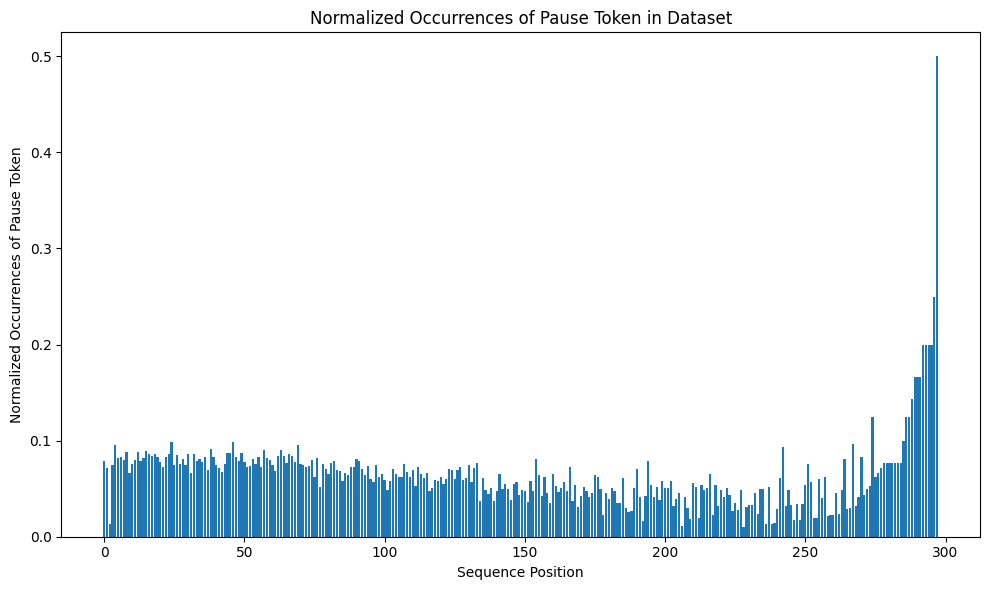

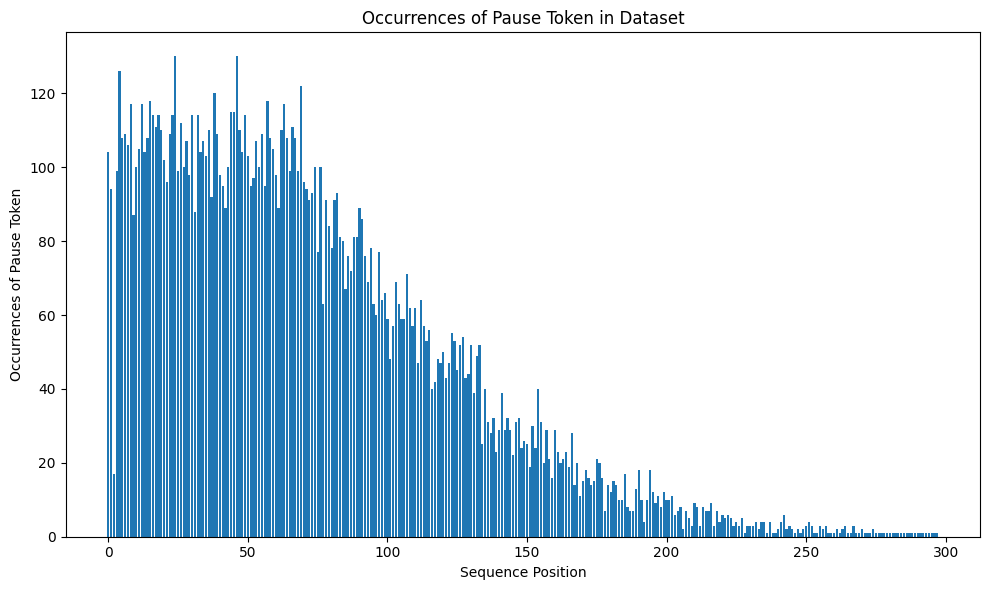

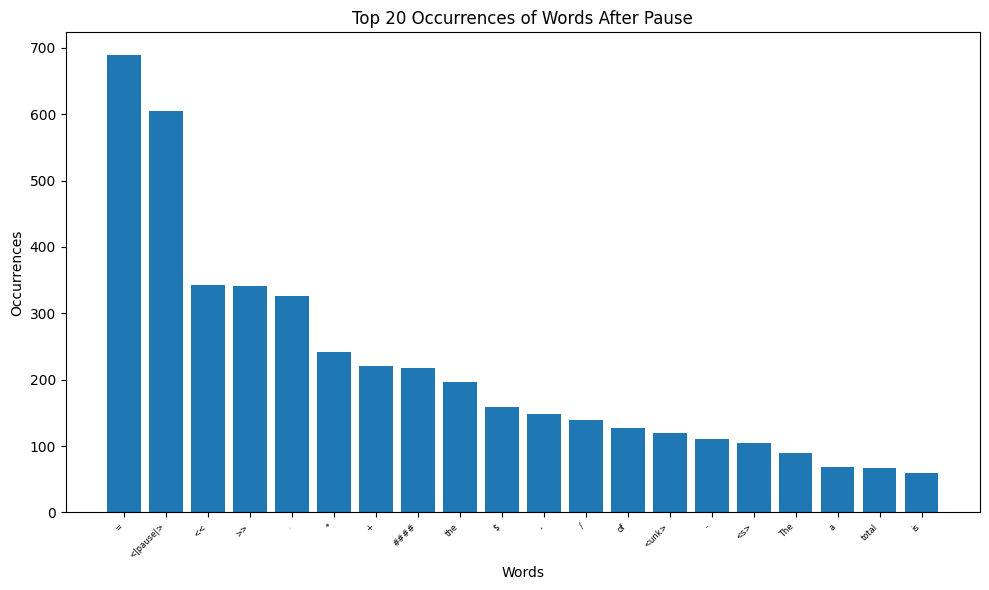

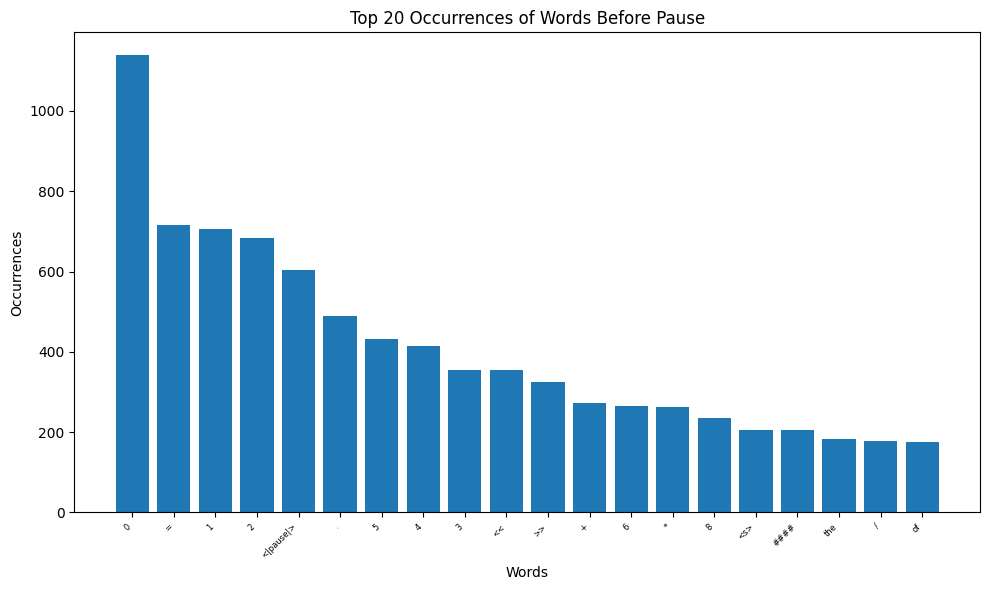

KL divergence From Random Pause Injection:  0.0
####################################################################################################
####################################################################################################
########## STATS FOR  rc_mistral_delta_reward_outer_loop_1.json ##########


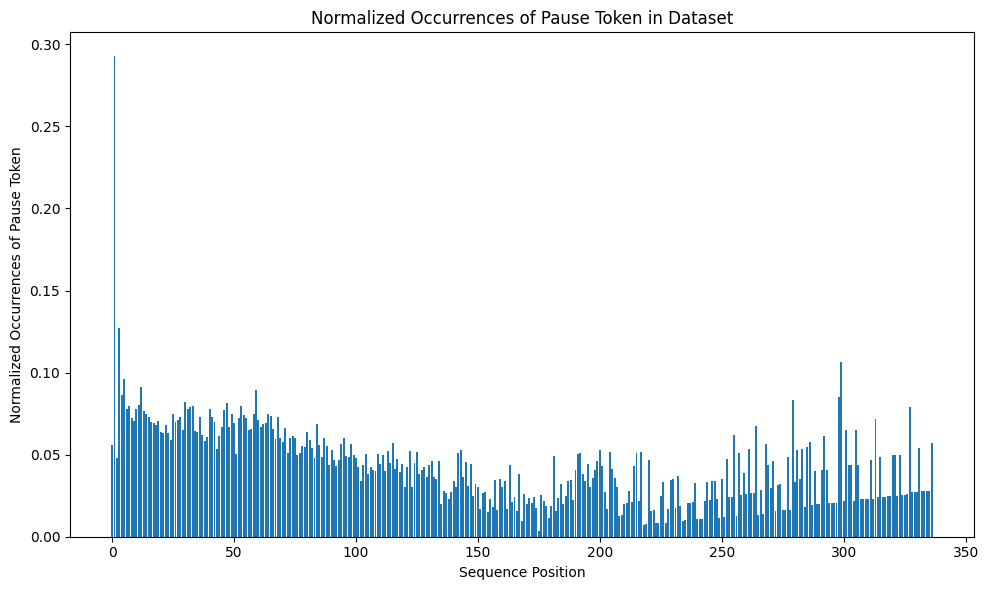

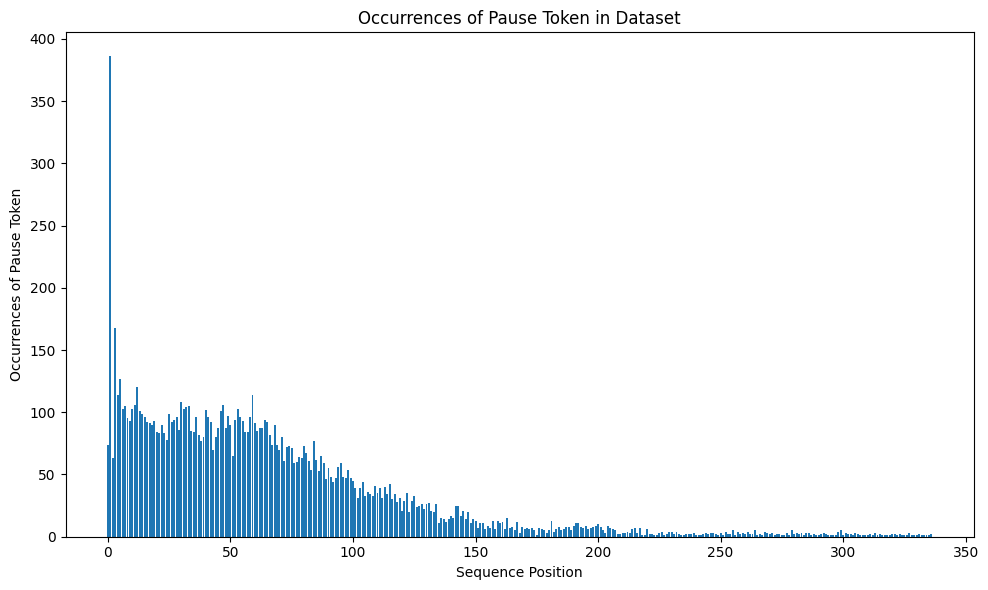

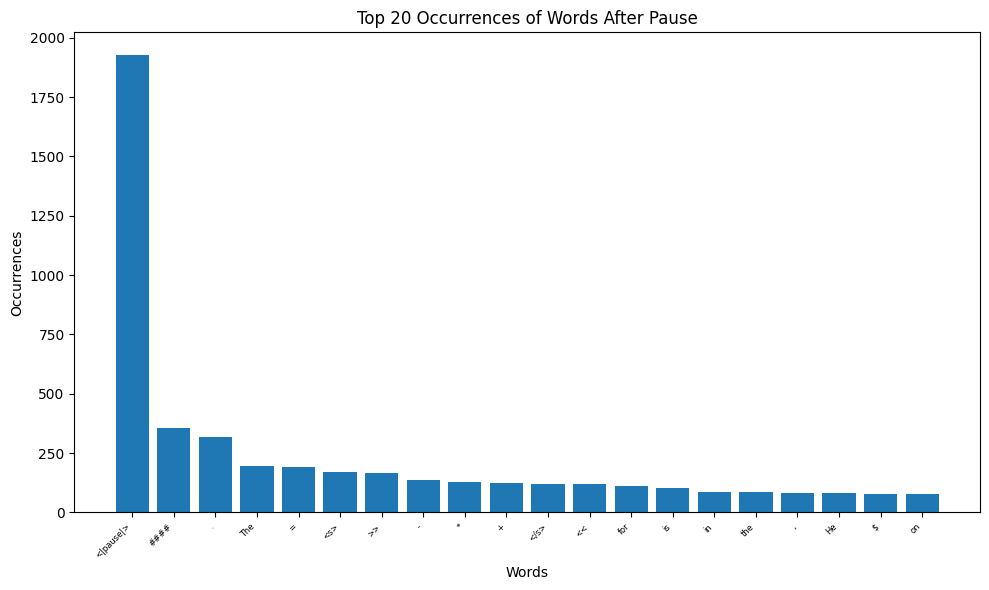

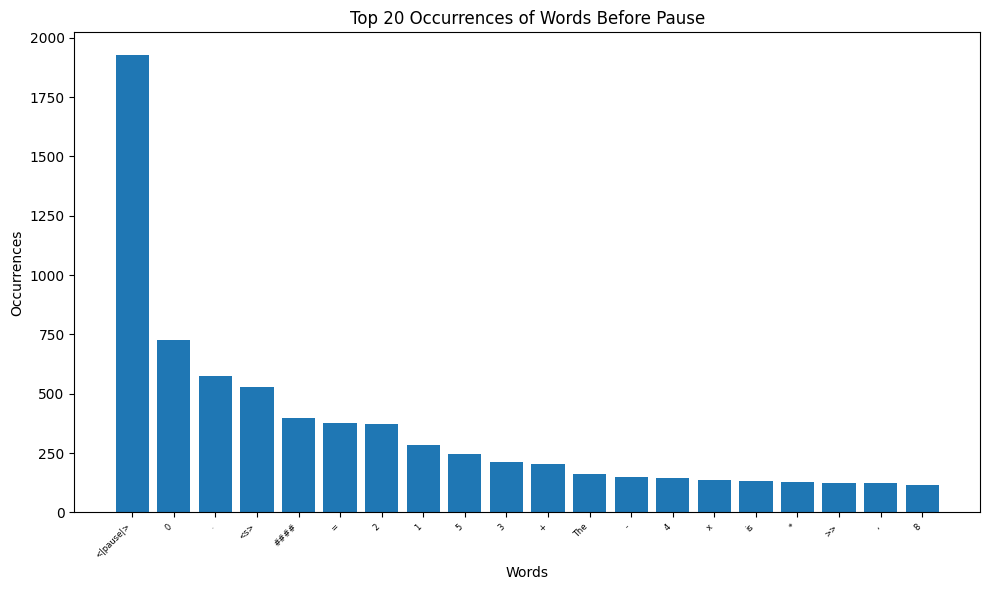

/tmp/ipykernel_4134429/2533323029.py:41: RuntimeWarning: divide by zero encountered in divide
  kl_div = np.sum(np.where((p != 0) & (q != 0), p * np.log(p / q), 0))
/tmp/ipykernel_4134429/2533323029.py:41: RuntimeWarning: divide by zero encountered in log
  kl_div = np.sum(np.where((p != 0) & (q != 0), p * np.log(p / q), 0))
/tmp/ipykernel_4134429/2533323029.py:41: RuntimeWarning: invalid value encountered in multiply
  kl_div = np.sum(np.where((p != 0) & (q != 0), p * np.log(p / q), 0))


####################################################################################################
####################################################################################################
########## STATS FOR  rc_mistral_correctness_reward_outer_loop_1.json ##########


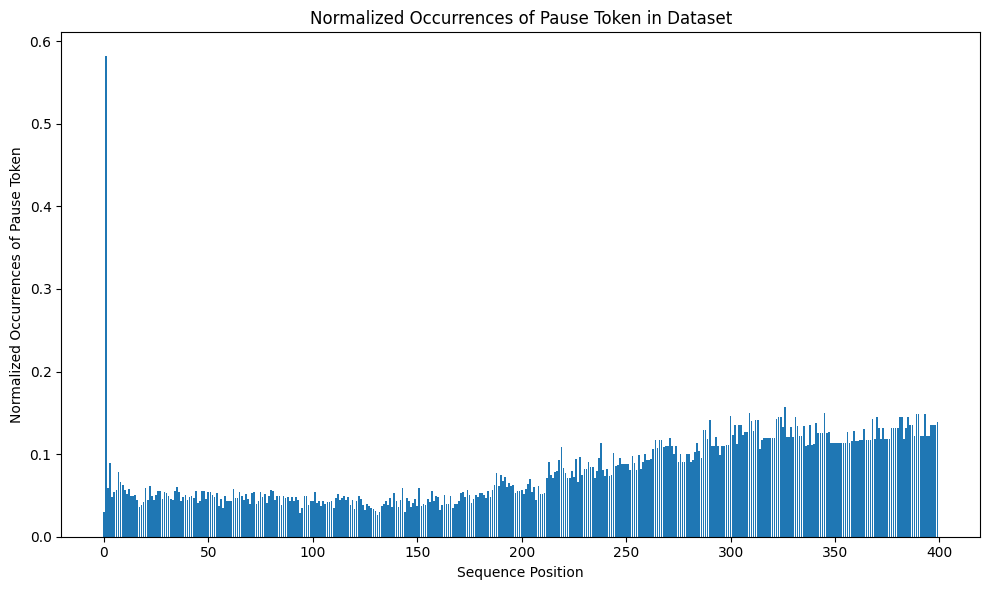

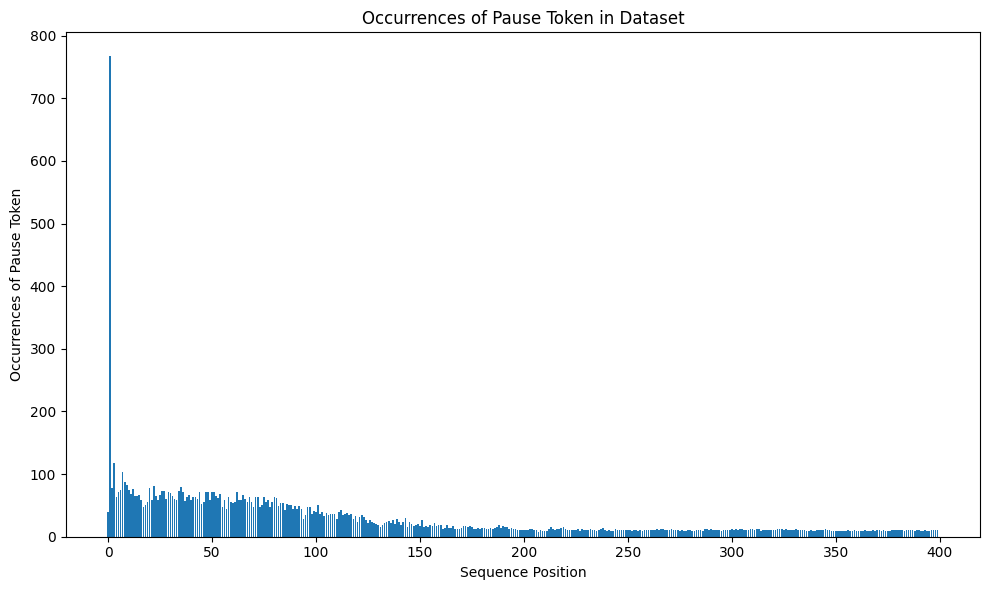

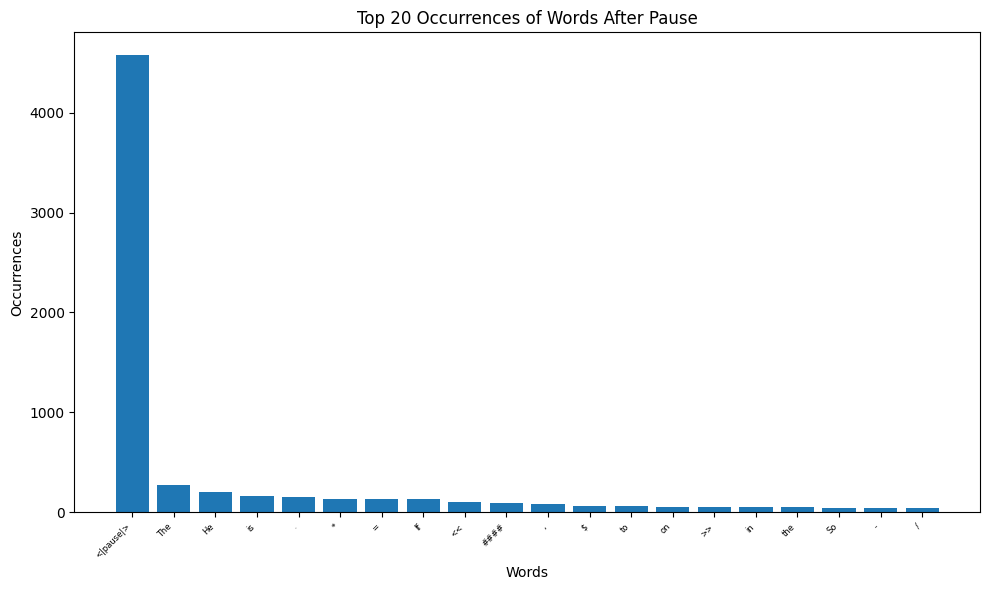

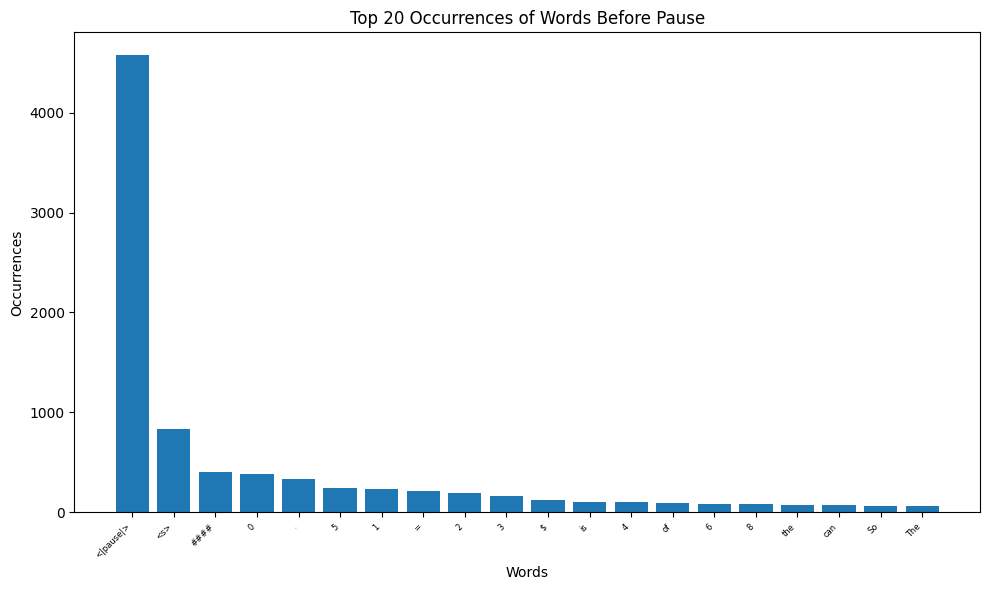

####################################################################################################
####################################################################################################
########## STATS FOR  rc_mistral_outer_loop_0.json ##########


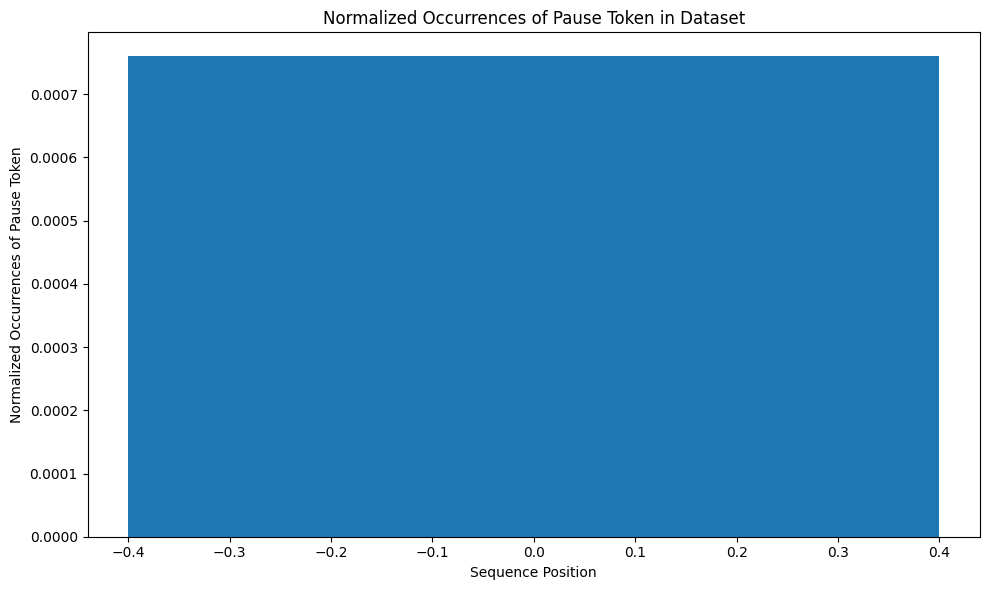

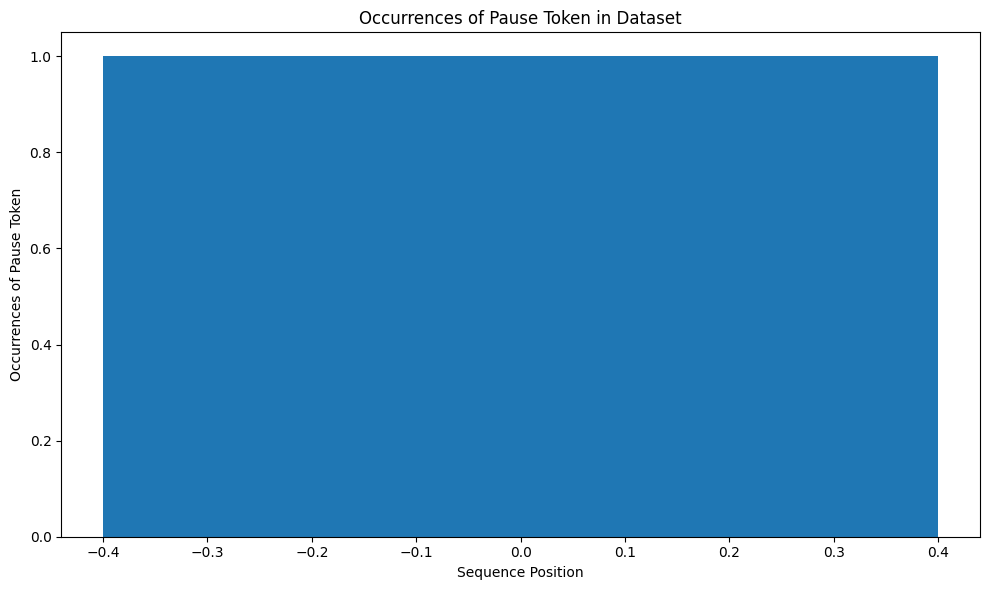

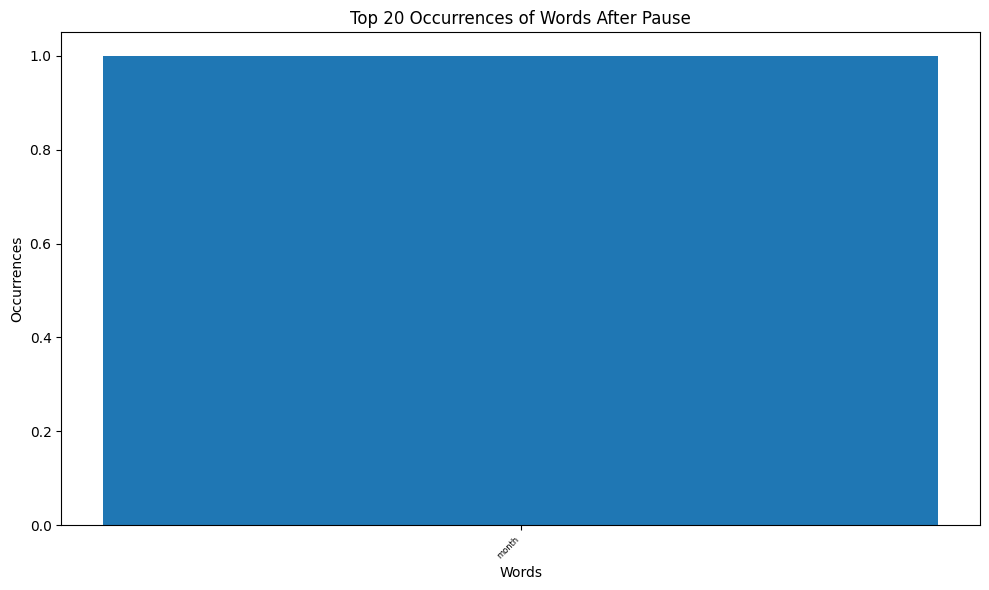

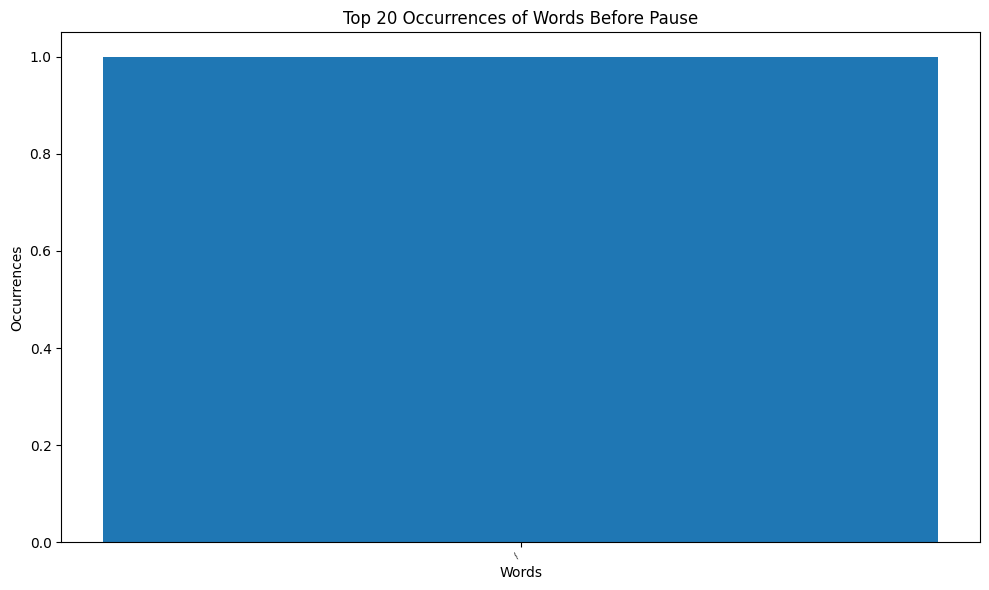

####################################################################################################
####################################################################################################
########## STATS FOR  rc_mistral_delta_reward_outer_loop_2.json ##########


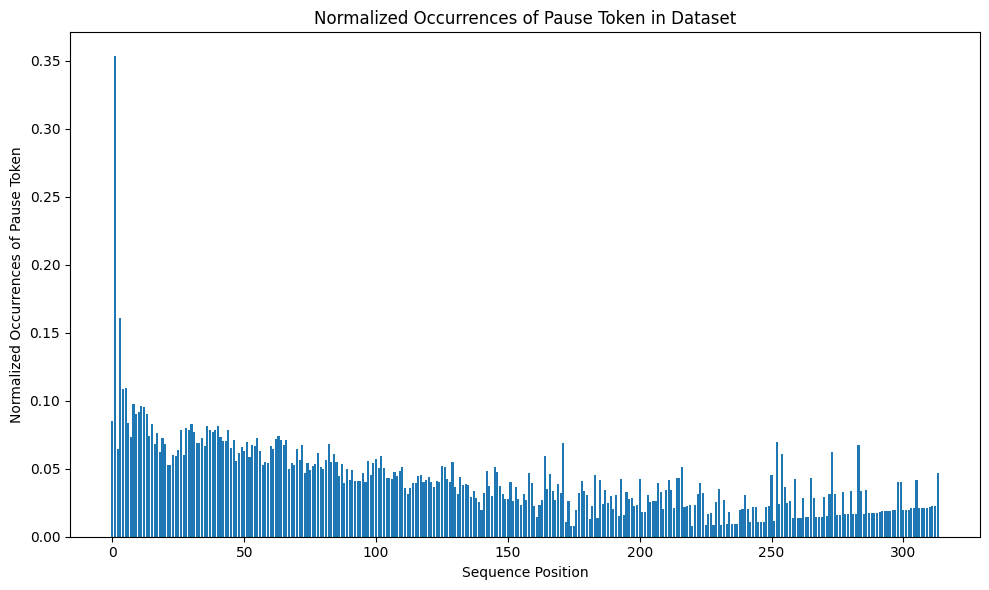

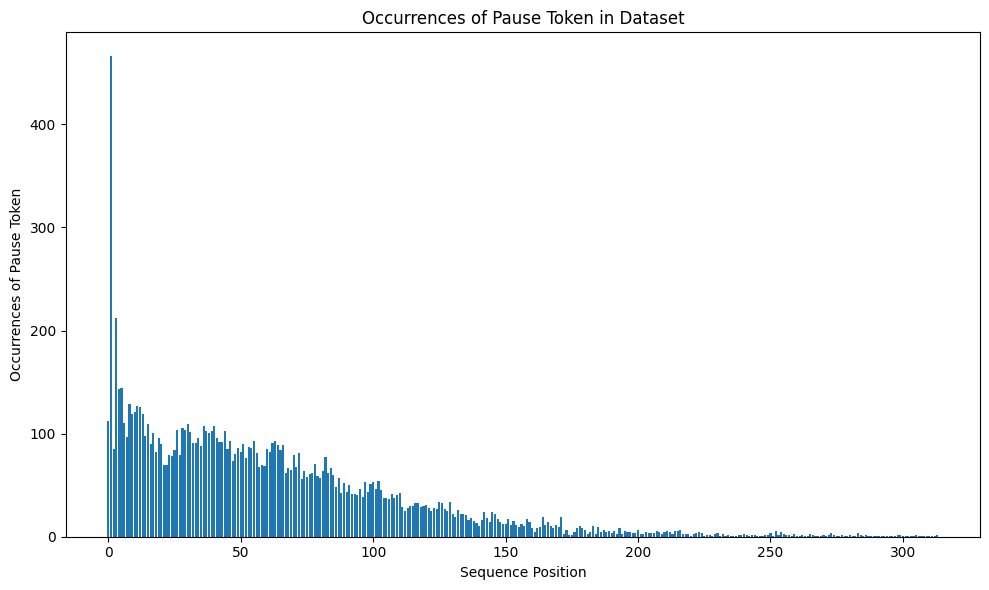

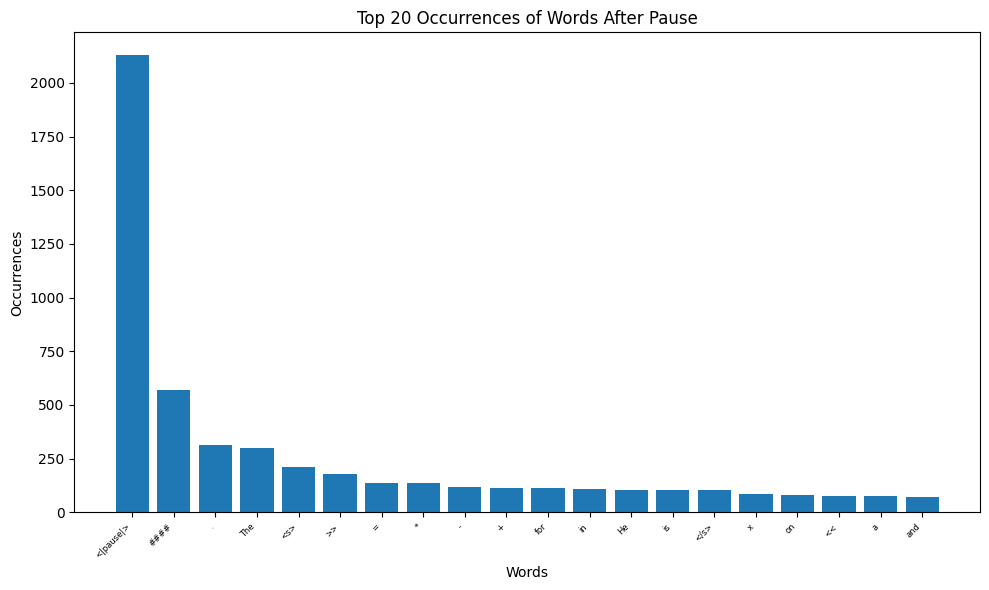

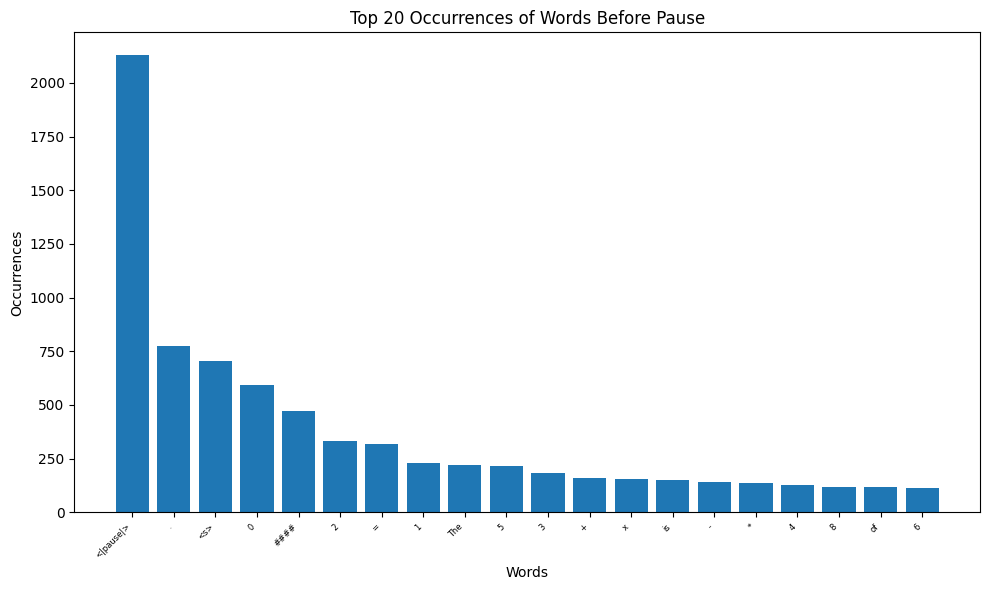

####################################################################################################
####################################################################################################
########## STATS FOR  rc_mistral_correctness_reward_outer_loop_2.json ##########


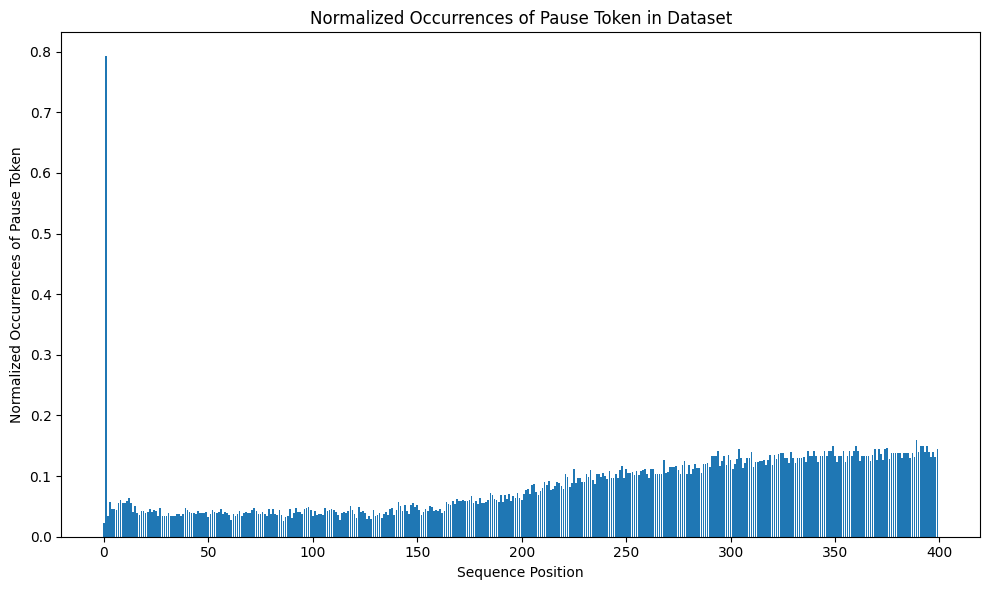

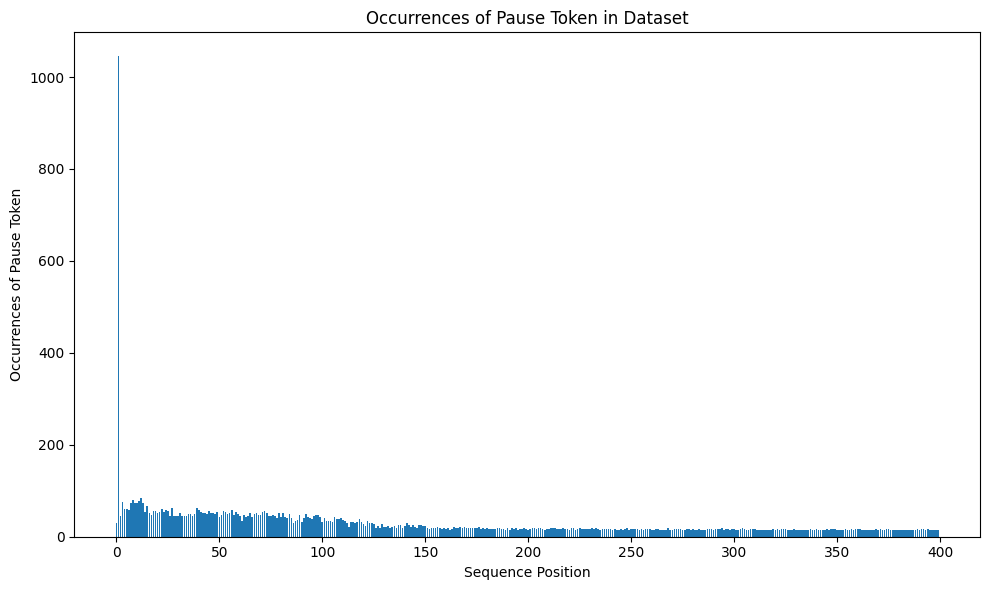

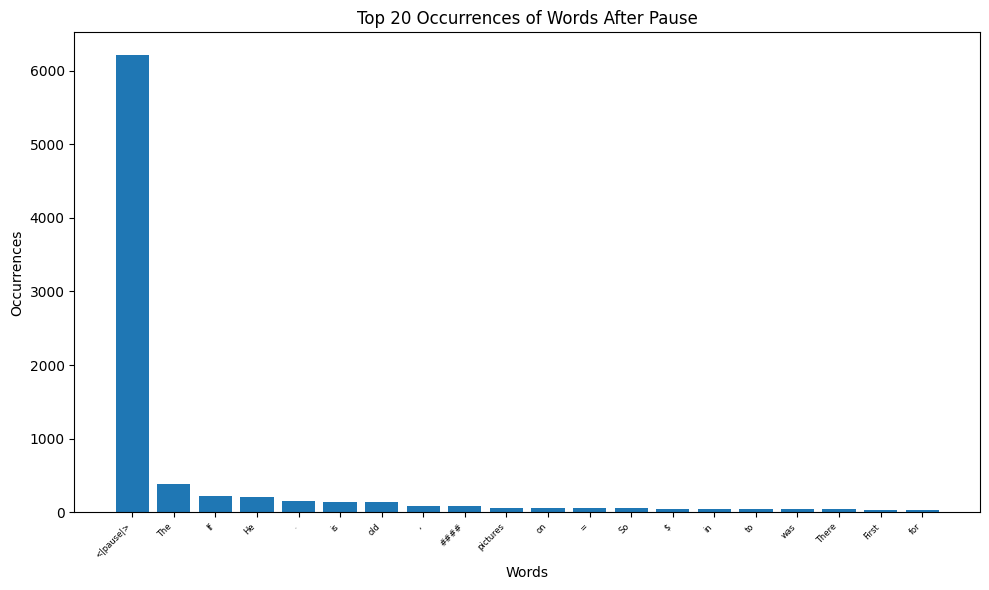

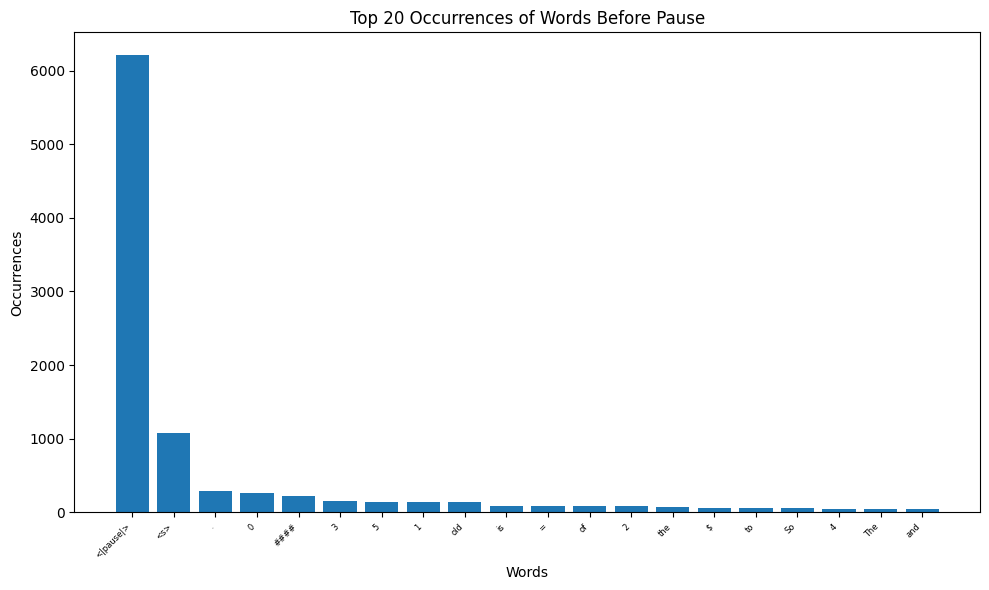

####################################################################################################


In [56]:
kl_divs = {}
print("#"*100)
print("########## STATS FOR RANDOM PAUSE INJECTION ##########")
r_inj = pause_injection_stats(list(map(lambda x: x["answer"],random_pause_injected_mistral)),mistral_pause_augm_tokenizer)
plot_pause_token_occurrences(r_inj)
plot_word_occurrences(r_inj["words_after_pause"], top_n=20, title='After Pause')
plot_word_occurrences(r_inj["words_before_pause"], top_n=20, title='Before Pause')
print("KL divergence From Random Pause Injection: ", kl_divergence_from_counts(r_inj["pause_token_occurence_positions"],r_inj["pause_token_occurence_positions"] ))
print("#"*100)

for key in name2data:
    print("#"*100)
    print("########## STATS FOR ", key, "##########")
    res = pause_injection_stats(list(map(lambda x: x["output"],name2data[key])),mistral_pause_augm_tokenizer)
    plot_pause_token_occurrences(res)
    plot_word_occurrences(res["words_after_pause"], top_n=20, title='After Pause')
    plot_word_occurrences(res["words_before_pause"], top_n=20, title='Before Pause')
    kl_divs[key] = kl_divergence_from_counts(r_inj["pause_token_occurence_positions"],res["pause_token_occurence_positions"] )

    print("#"*100)


In [58]:
for key in kl_divs:
    print(key, kl_divs[key])

rc_mistral_delta_reward_outer_loop_1.json 0.12105537834969002
rc_mistral_correctness_reward_outer_loop_1.json 0.5792135849094544
rc_mistral_outer_loop_0.json -0.012860885633977512
rc_mistral_delta_reward_outer_loop_2.json 0.08322877771789908
rc_mistral_correctness_reward_outer_loop_2.json 0.8245515277478416


In [61]:
from src.utils import count_num_token_occurences
count_num_token_occurences(pause_token_id,mistral_pause_augm_tokenizer, "HI <|pause|> there")